In [6]:
# imports
import pandas as pd

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import os
import sys
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# cnn imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, LSTM, Bidirectional, Layer, Input
from tensorflow.python.keras.layers import Input, Dense, Embedding, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from numpy import array

from datetime import datetime


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [7]:
local_bert_path =   '<your local BERT path>' # change as needed
#data_path = '<your data path>'  # path to ner_dataset.csv file , from 
data_path = 'data\\'  # path to ner_dataset.csv file , from 

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

In [8]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

In [9]:
# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 30

In [13]:
# Load data
bodies_df = pd.read_csv("train_bodies.csv")
stances_df =  pd.read_csv("train_stances.csv")

# Examine data shape
bodies_df.shape
bodies_df.head()

stances_df.shape
stances_df.head()

stances_df.head()
#combine body and stance tables
combined = pd.concat([stances_df.set_index('Body ID'),bodies_df.set_index('Body ID')], axis=1, join='inner').reset_index()

combined.shape

combined.head()

combined_df_t=combined[['Headline', 'articleBody', 'Stance']]

combined_df_t.head()

# Extract column for just labels
labels_t = combined_df_t['Stance']


In [14]:
# Examine data shape
bodies_df.shape

(1683, 2)

In [15]:
stances_df.shape

(49972, 3)

In [16]:
combined_df_t.head()

,Headline,articleBody,Stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",disagree


In [17]:
combined_df_t.shape

(49972, 3)

In [18]:
# Drop columns that are strings
all_data_processed = combined_df_t.drop(['Stance'], axis=1)
#all_data_processed = combined_df_t.drop(['articleBody'], axis=1)

In [19]:
new_labels1= labels_t.copy()

new_labels1[new_labels1=='agree']=3
new_labels1[new_labels1=='unrelated']=2
new_labels1[new_labels1=='disagree']=0
new_labels1[new_labels1=='discuss']=1

#new_labels1[new_labels1=='agree']= np.array(0,0,0,1)
#new_labels1[new_labels1=='unrelated']=1
#new_labels1[new_labels1=='disagree']=0
#new_labels1[new_labels1=='discuss']=1

#new_labels1h = pd.get_dummies(new_labels1)

new_labels1h = np_utils.to_categorical(new_labels1)

#dummy_y = np_utils.to_categorical(new_labels1)

In [20]:
new_labels1h

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [21]:
all_data_processed.head()

,Headline,articleBody
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's..."


In [25]:
# Set some variables to hold test, dev, and training data.
test_data, test_labels = all_data_processed[:1000], new_labels1[:1000]
dev_data, dev_labels = all_data_processed[1001:3000], new_labels1[1001:3000]
train_data, train_labels = all_data_processed[3001:], new_labels1[3001:]

In [26]:
test_labels_1h = new_labels1h[:1000]
dev_labels_1h = new_labels1h[1001:3000]
train_labels_1h = new_labels1h[3001:]

In [27]:
new_labels1h

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [28]:
len(test_data)

1000

In [29]:
len(train_data)

46971

In [16]:
# Used GLoVE embeddings
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [17]:
def sent_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    
    # TODO - Update Regular Expression for parsing (TINA)
    # Improvement Option (Remove trailing 's') Check Missing list for optimization
    
    #re.sub('[^A-Za-z0-9]+', '', mystring)
    #cleanString = re.sub('\W+','', string ) 
    
    bad_chars = [';', ':', '!', "*"] 
    
    text_ids = []
    example = []
    sentences = sentences.replace('.','')
    sentences = sentences.replace('\'','')
    sentences = sentences.replace(',','')
    sentences = sentences.replace('$','')
    sentences = sentences.replace('/',' ')
    sentences = sentences.replace('','')
    for word in sentences.split(' '):
        #word.lower()
        temp = word.lower()
        #temp.replace('\'','')
        if temp in embeddings_dict:
            example.append(embeddings_dict[temp])
        else:
            print("Missing ", temp)            
    text_ids.append(example)

    return  text_ids   

In [18]:
all_data_emb = all_data_processed.copy()

In [19]:
all_data_processed['Headline'][1]

'Hundreds of Palestinians flee floods in Gaza as Israel opens dams'

In [20]:
train_data

,Headline,articleBody
3001,Jihadi John ‘identified as British man from We...,Some iPhone 6 users say they are literally pul...
3002,Dog abandoned at Scotland train station with s...,Offers have been pouring in to re-home a dog f...
3003,The Man Who Says Comcast Got Him Fired Has Fil...,A photo provided by the Nicaraguan Army shows ...
3004,Iraqi media says ISIS militants have contracte...,It's what national security organizations have...
3005,An accidental delivery of arms to the Islamic ...,We're just two months away from the Apple Watc...
...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,(CNN) -- Boko Haram laughed off Nigeria's anno...
49968,Brian Williams slams social media for speculat...,Along with unveiling the Apple Watch earlier t...
49969,Mexico Says Missing Students Not Found In Firs...,The bodies found in a mass grave were confirme...
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,Rep. Duncan Hunter (R-CA) told Greta Van Suste...


In [21]:
all_data_token = combined_df_t['Headline']+combined_df_t['articleBody']

In [22]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(all_data_token)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(test_data)
#print(encoded_docs)

In [23]:
embeddings_index_ex = dict()
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index_ex[word] = coefs
#    f.close()
print('Loaded %s word vectors.' % len(embeddings_index_ex))

Loaded 400000 word vectors.


In [24]:
# create a weight matrix for words in training docs
embedding_matrix_ex = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index_ex.get(word)
    if embedding_vector is not None:
        embedding_matrix_ex[i] = embedding_vector

In [25]:
# This is a hepler method to display and plot results
def showResults(history):
    val_acc = np.array(history.history['val_main_output_acc'])
    train_ac = np.array(history.history['main_output_acc'])
    print("Best validation Accuracy: %.4f" % max(val_acc))
    print("Best train Accuracy: %.4f" %  max(train_ac))

    plt.figure(figsize=(14, 4))
    ax = plt.subplot(121)

    # Plot Loss Vs Epoch for Train and validation Sets
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( [i + 1 for i in range(len(history.history['loss']))], history.history['loss'],  '-gD', marker='o', label="Training loss")
    plt.plot( [i + 1 for i in range(len(history.history['val_loss']))], history.history['val_loss'],  '-bD', marker='o', label="Validation loss")
    plt.legend(loc="best")

    # Plot Accuracy Vs Epoch for Train and validation Sets
    ax = plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['main_output_acc']))], history.history['main_output_acc'],  '-gD', marker='o', label="Train Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['val_main_output_acc']))], history.history['val_main_output_acc'],  '-bD', marker='o', label="Validation Accuracy")
    plt.legend(loc="best")

In [26]:
def encodeDoc(data, size):
# integer encode the documents
#encoded_docs = t.texts_to_sequences(all_data_processed['Headline'])
#encoded_docs = t.texts_to_sequences(train_data)
    encoded_docs = t.texts_to_sequences(data)

    #print(encoded_docs)
    # pad documents to a max length of 4 words
    max_length = size
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    #print(padded_docs)
    
    return padded_docs

In [27]:
padded_docs_h = encodeDoc(dev_data['Headline'],10)
padded_docs_b = encodeDoc(dev_data['articleBody'], 35)
padded_test_docs_h = encodeDoc(test_data['Headline'],10)
padded_test_docs_b = encodeDoc(test_data['articleBody'], 35)


In [37]:
# Note that we can name any layer by passing it a "name" argument.
headline_input = Input(shape=(10,), dtype='int32', name='headline_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
emb_h = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=10, trainable=False)(headline_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out_h = LSTM(32)(emb_h)
#headline_out = Dense(1, activation='sigmoid', name='headline_out')(lstm_out_h)
headline_out = Dense(4, activation='softmax', name='headline_out')(lstm_out_h)

In [38]:
# Note that we can name any layer by passing it a "name" argument.
body_input = Input(shape=(35,), dtype='int32', name='body_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
emb_b = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=35, trainable=False)(body_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out_b = LSTM(32)(emb_b)
#body_out = Dense(1, activation='sigmoid', name='body_out')(lstm_out_b)
body_out = Dense(4, activation='softmax', name='body_out')(lstm_out_b)

In [39]:
#x = keras.layers.concatenate([headline_out, body_out])
conc = tf.keras.layers.concatenate([headline_out, body_out])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(conc)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(4, activation='softmax', name='main_output')(x)
#main_output = Dense(3, activation='sigmoid', name='main_output')(x)

In [40]:
model5 = Model(inputs=[headline_input, body_input], outputs=[main_output, headline_out, body_out ])

In [41]:
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
headline_input (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 50)       2487000     headline_input[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       2487000     body_input[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LS

In [42]:
model5.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
#model5.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
dev_labels_1h.shape

(1999, 4)

In [44]:
dev_labels_1h

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [45]:
# fit the model
batch_size = 30
#history = model5.fit([padded_docs_h, padded_docs_b], [dev_labels,dev_labels,dev_labels], batch_size=batch_size, epochs=80, validation_split= 0.2)
history = model5.fit([padded_docs_h, padded_docs_b], [dev_labels_1h,dev_labels_1h,dev_labels_1h], batch_size=batch_size, epochs=80, validation_split= 0.2)

Train on 1599 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/80
1599/1599 [==============================] - 7s 4ms/sample - loss: 2.8962 - main_output_loss: 0.9920 - headline_out_loss: 0.9976 - body_out_loss: 0.9066 - main_output_acc: 0.6836 - headline_out_acc: 0.6448 - body_out_acc: 0.7211 - val_loss: 2.4776 - val_main_output_loss: 0.8983 - val_headline_out_loss: 0.8073 - val_body_out_loss: 0.7719 - val_main_output_acc: 0.7475 - val_headline_out_acc: 0.7425 - val_body_out_acc: 0.7475
Epoch 2/80
1599/1599 [==============================] - 5s 3ms/sample - loss: 2.4006 - main_output_loss: 0.8343 - headline_out_loss: 0.7897 - body_out_loss: 0.7767 - main_output_acc: 0.7436 - headline_out_acc: 0.7430 - body_out_acc: 0.7442 - val_loss: 2.3568 - val_main_output_loss: 0.7969 - val_headline_out_loss: 0.7837 - val_body_out_loss: 0.7762 - val_main_output_acc: 0.7475 - val_headline_out_acc: 0.7450 - val_body_out_acc: 0.7475
Epoch 3/80
1599/1599 [=======

Epoch 19/80
1599/1599 [==============================] - 6s 4ms/sample - loss: 1.8093 - main_output_loss: 0.5250 - headline_out_loss: 0.6531 - body_out_loss: 0.6312 - main_output_acc: 0.7905 - headline_out_acc: 0.7461 - body_out_acc: 0.7573 - val_loss: 2.5443 - val_main_output_loss: 1.0185 - val_headline_out_loss: 0.7931 - val_body_out_loss: 0.7327 - val_main_output_acc: 0.6525 - val_headline_out_acc: 0.7300 - val_body_out_acc: 0.7475
Epoch 20/80
1599/1599 [==============================] - 7s 4ms/sample - loss: 1.7760 - main_output_loss: 0.5008 - headline_out_loss: 0.6496 - body_out_loss: 0.6255 - main_output_acc: 0.7992 - headline_out_acc: 0.7455 - body_out_acc: 0.7655 - val_loss: 2.4653 - val_main_output_loss: 0.9539 - val_headline_out_loss: 0.7832 - val_body_out_loss: 0.7281 - val_main_output_acc: 0.6800 - val_headline_out_acc: 0.7475 - val_body_out_acc: 0.7425
Epoch 21/80
1599/1599 [==============================] - 7s 4ms/sample - loss: 1.7057 - main_output_loss: 0.4669 - headlin

Epoch 38/80
1599/1599 [==============================] - 5s 3ms/sample - loss: 1.1201 - main_output_loss: 0.2150 - headline_out_loss: 0.4767 - body_out_loss: 0.4284 - main_output_acc: 0.9250 - headline_out_acc: 0.7942 - body_out_acc: 0.8274 - val_loss: 3.2899 - val_main_output_loss: 1.6303 - val_headline_out_loss: 0.9214 - val_body_out_loss: 0.7382 - val_main_output_acc: 0.7225 - val_headline_out_acc: 0.7325 - val_body_out_acc: 0.7600
Epoch 39/80
1599/1599 [==============================] - 5s 3ms/sample - loss: 1.1358 - main_output_loss: 0.2289 - headline_out_loss: 0.4753 - body_out_loss: 0.4316 - main_output_acc: 0.9187 - headline_out_acc: 0.7886 - body_out_acc: 0.8318 - val_loss: 3.1693 - val_main_output_loss: 1.5045 - val_headline_out_loss: 0.9175 - val_body_out_loss: 0.7473 - val_main_output_acc: 0.6350 - val_headline_out_acc: 0.6300 - val_body_out_acc: 0.7450
Epoch 40/80
1599/1599 [==============================] - 6s 4ms/sample - loss: 1.0915 - main_output_loss: 0.2053 - headlin

Epoch 57/80
1599/1599 [==============================] - 6s 3ms/sample - loss: 0.8414 - main_output_loss: 0.1058 - headline_out_loss: 0.4018 - body_out_loss: 0.3338 - main_output_acc: 0.9656 - headline_out_acc: 0.8174 - body_out_acc: 0.8593 - val_loss: 3.7601 - val_main_output_loss: 1.8143 - val_headline_out_loss: 1.0655 - val_body_out_loss: 0.8803 - val_main_output_acc: 0.7250 - val_headline_out_acc: 0.6700 - val_body_out_acc: 0.7400
Epoch 58/80
1599/1599 [==============================] - 6s 4ms/sample - loss: 0.7990 - main_output_loss: 0.0919 - headline_out_loss: 0.3855 - body_out_loss: 0.3216 - main_output_acc: 0.9669 - headline_out_acc: 0.8299 - body_out_acc: 0.8630 - val_loss: 3.8722 - val_main_output_loss: 1.9741 - val_headline_out_loss: 1.0518 - val_body_out_loss: 0.8463 - val_main_output_acc: 0.7275 - val_headline_out_acc: 0.6650 - val_body_out_acc: 0.7175
Epoch 59/80
1599/1599 [==============================] - 5s 3ms/sample - loss: 0.8038 - main_output_loss: 0.1010 - headlin

Epoch 76/80
1599/1599 [==============================] - 6s 3ms/sample - loss: 0.7126 - main_output_loss: 0.0729 - headline_out_loss: 0.3452 - body_out_loss: 0.2945 - main_output_acc: 0.9769 - headline_out_acc: 0.8361 - body_out_acc: 0.8724 - val_loss: 4.1705 - val_main_output_loss: 2.0650 - val_headline_out_loss: 1.1789 - val_body_out_loss: 0.9265 - val_main_output_acc: 0.6925 - val_headline_out_acc: 0.6000 - val_body_out_acc: 0.6575
Epoch 77/80
1599/1599 [==============================] - 5s 3ms/sample - loss: 0.7058 - main_output_loss: 0.0758 - headline_out_loss: 0.3493 - body_out_loss: 0.2807 - main_output_acc: 0.9756 - headline_out_acc: 0.8399 - body_out_acc: 0.8774 - val_loss: 4.0770 - val_main_output_loss: 1.9932 - val_headline_out_loss: 1.1525 - val_body_out_loss: 0.9313 - val_main_output_acc: 0.7200 - val_headline_out_acc: 0.6025 - val_body_out_acc: 0.6800
Epoch 78/80
1599/1599 [==============================] - 6s 4ms/sample - loss: 0.6865 - main_output_loss: 0.0689 - headlin

In [48]:
# evaluate the model
accuracy = model5.evaluate([padded_test_docs_h,padded_test_docs_b], [test_labels_1h,test_labels_1h,test_labels_1h], verbose=1)
print('Loss: %f' % (accuracy[0]))
print('Combined Loss: %f' % (accuracy[1]))
print('Headline Loss: %f' % (accuracy[2]))
print('Body Loss: %f' % (accuracy[3]))
print('Accuracy: %f' % (accuracy[4]))
print('Headline Accuracy: %f' % (accuracy[5]))
print('Body Accuracy: %f' % (accuracy[6]))

1000/1000 [==============================] - 1s 1ms/sample - loss: 4.8908 - main_output_loss: 2.4916 - headline_out_loss: 1.3055 - body_out_loss: 1.0937 - main_output_acc: 0.6450 - headline_out_acc: 0.5820 - body_out_acc: 0.6670
Loss: 4.890821
Combined Loss: 2.491637
Headline Loss: 1.305522
Body Loss: 1.093662
Accuracy: 0.645000
Headline Accuracy: 0.582000
Body Accuracy: 0.667000


Best validation Accuracy: 0.7500
Best train Accuracy: 0.9794


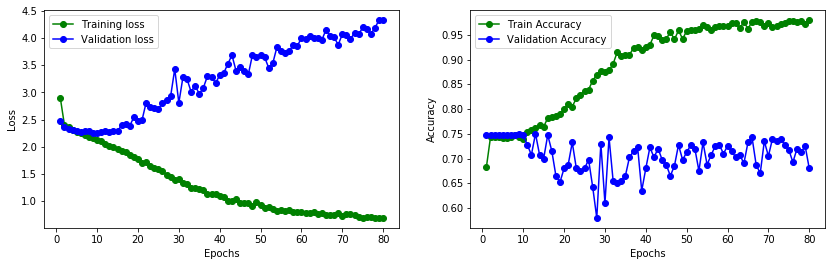

In [49]:
showResults(history)

In [50]:
results = model5.predict([padded_test_docs_h,padded_test_docs_b])

In [51]:
results

[array([[8.62082572e-07, 9.75464821e-01, 2.44632531e-02, 7.11415996e-05],
        [3.73578009e-11, 3.45147242e-07, 9.99999642e-01, 1.50055333e-11],
        [3.68234498e-04, 1.22317625e-02, 9.87210035e-01, 1.89994113e-04],
        ...,
        [5.76453342e-04, 1.02635235e-01, 8.95814061e-01, 9.74289549e-04],
        [1.09413661e-04, 9.16830916e-03, 9.90664363e-01, 5.78919389e-05],
        [7.48467301e-07, 7.43054450e-01, 2.56940961e-01, 3.86581814e-06]],
       dtype=float32),
 array([[4.3781361e-04, 1.3053894e-01, 8.6738670e-01, 1.6365387e-03],
        [1.6283123e-02, 3.4433257e-02, 9.4856787e-01, 7.1566598e-04],
        [4.1454200e-02, 5.2754825e-01, 3.3513960e-01, 9.5857941e-02],
        ...,
        [7.1745052e-04, 1.0040237e-01, 8.9863300e-01, 2.4714187e-04],
        [4.8401352e-02, 7.9631992e-02, 8.3365178e-01, 3.8314916e-02],
        [6.5961809e-05, 2.5650207e-03, 9.9648678e-01, 8.8229659e-04]],
       dtype=float32),
 array([[1.9153826e-03, 8.5604006e-01, 1.3065912e-01, 1.138547

In [54]:
test_labels_1h


array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [10]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [48]:
tok = tokenizer.tokenize(all_data_processed['Headline'][1])
tok

['Hundreds',
 'of',
 'Palestinians',
 'flee',
 'floods',
 'in',
 'Gaza',
 'as',
 'Israel',
 'opens',
 'dams']

In [49]:
tok.insert(0,'[CLS]')

In [50]:
tokenizer.convert_tokens_to_ids(tok)

[101, 25793, 1104, 23755, 10556, 15501, 1107, 15109, 1112, 3103, 7086, 20245]

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [51]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


In [54]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open(data_path + 'ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()
text

['Sentence #,Word,POS,Tag\n',
 'Sentence: 1,Thousands,NNS,O\n',
 ',of,IN,O\n',
 ',demonstrators,NNS,O\n',
 ',have,VBP,O\n',
 ',marched,VBN,O\n',
 ',through,IN,O\n',
 ',London,NNP,B-geo\n',
 ',to,TO,O\n',
 ',protest,VB,O\n',
 ',the,DT,O\n',
 ',war,NN,O\n',
 ',in,IN,O\n',
 ',Iraq,NNP,B-geo\n',
 ',and,CC,O\n',
 ',demand,VB,O\n',
 ',the,DT,O\n',
 ',withdrawal,NN,O\n',
 ',of,IN,O\n',
 ',British,JJ,B-gpe\n',
 ',troops,NNS,O\n',
 ',from,IN,O\n',
 ',that,DT,O\n',
 ',country,NN,O\n',
 ',.,.,O\n',
 'Sentence: 2,Families,NNS,O\n',
 ',of,IN,O\n',
 ',soldiers,NNS,O\n',
 ',killed,VBN,O\n',
 ',in,IN,O\n',
 ',the,DT,O\n',
 ',conflict,NN,O\n',
 ',joined,VBD,O\n',
 ',the,DT,O\n',
 ',protesters,NNS,O\n',
 ',who,WP,O\n',
 ',carried,VBD,O\n',
 ',banners,NNS,O\n',
 ',with,IN,O\n',
 ',such,JJ,O\n',
 ',slogans,NNS,O\n',
 ',as,IN,O\n',
 ',"""",``,O\n',
 ',Bush,NNP,B-per\n',
 ',Number,NN,O\n',
 ',One,CD,O\n',
 ',Terrorist,NN,O\n',
 ',"""",``,O\n',
 ',and,CC,O\n',
 ',"""",``,O\n',
 ',Stop,VB,O\n',
 ',the,DT,O\n'

In [55]:
text = all_data_processed['Headline'][1]

In [56]:


# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    sent, word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (sent[:8] == 'Sentence'):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word

    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]


ValueError: not enough values to unpack (expected 4, got 1)